In [1]:
from IPython.core.display import HTML
HTML('<link href="https://fonts.googleapis.com/css2?family=IBM+Plex+Sans:ital,wght@0,400;0,700;1,400;1,700&display=swap" rel="stylesheet">')

In [2]:
import urllib
response = urllib.request.urlopen("https://gist.githubusercontent.com/sgttwld/9deff60facb16918e54410cca3d65648/raw")
css = str(response.read().decode("utf-8"))
HTML("<style type='text/css'>"+css+"</style>")

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from RD_BA import BA
from RD_GD import GD
from RD_MA import MA, MA_iter

In [5]:
# plot settings
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,3)}, 
    style="white" # nicer layout
)
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('legend', fontsize=9)    # legend fontsize

In [6]:
def get_source(num):
    return tf.constant( np.random.beta(a=2,b=2,size=(num)) ) 

In [7]:
def legend_string(r):
    return 'beta={}\nN={}\n{} iterations\n{:.2f} seconds'.format(
        r['beta'],len(r['Xhat']),r['episodes'],r['elapsed'])

In [8]:
# parameters
beta = 15.0
num = 5000

# Rate-distortion: _Blahut-Arimoto_ vs. _gradient descent_ vs. _mapping approach_

Consider a continuous source $X$, for example distributed according to a beta distribution:

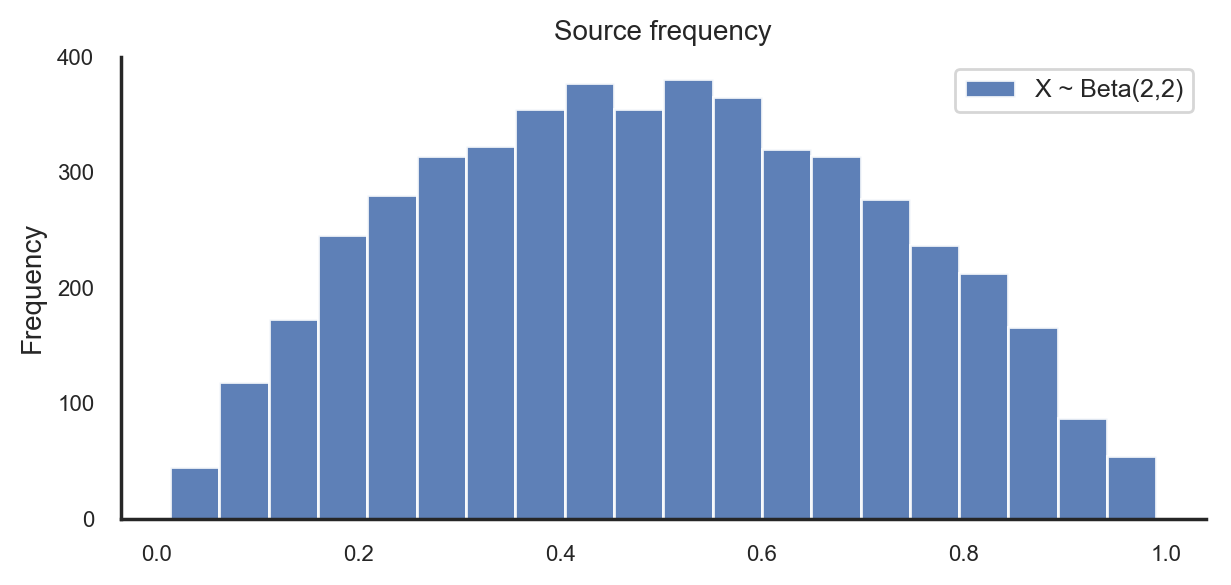

In [9]:
# source
X = get_source(num)
ax = pd.DataFrame(X).plot.hist(bins=20,alpha=.9,fontsize=8,title='Source frequency')
ax.legend([r'X ~ Beta(2,2)'])
sns.despine()
plt.show()

Below we compare three algorithms that are designed to find the minimum of the rate-distortion 
Lagrangian (a.k.a. _free energy_)
$$
F_{RD}(q(\hat X|X)) := \mathbb E[d(X,\hat X)] + \tfrac{1}{\beta} \, I(X;\hat X)
$$
with respect to conditional distributions $q(\hat X|X)$, where $d$ denotes a distortion 
function (e.g. the squared distance $d(s,t) = (s-t)^2$, which is chosen in the simulations below), and 
$$
I(X;\hat X) = \mathbb E_X [D_{KL}(q(\hat X|X)\| \mathbb E_X[q(\hat X|X)])]
$$ 
is the mutual information between the source $X$ and the reconstruction $\hat X$. All three algorithms 
make use of the fact that the rate-distortion Lagrangian $F_{RD}$ can be written as the optimum
$$
F_{RD}(q(\hat X|X)) = \min_{q(\hat X)} F_{aux}(q(\hat X|X), q(\hat X))
$$
where the auxiliary Lagrangian is defined as
$$
F_{aux}(q(\hat X|X), q(\hat X)):= \mathbb E[d(X,\hat X)] + \tfrac{1}{\beta} \, \mathbb E_X [D_{KL}(q(\hat X|X)\| q(\hat X))] ,
$$
since the optimal reconstruction distribution $q^\ast(\hat X)$ is simply given by the marginal 
$\mathbb E_X[q(\hat X|X)],$ and by construction we have 
$F_{RD}(\ \cdot \ ) = F_{aux}(\ \cdot \ ,\mathbb E_X[q(\hat X|X)])$. 

## 1. Blahut-Arimoto ([RD_BA.py](https://github.com/sgttwld/rate-distortion/blob/master/RD_BA.py))
When the Blahut-Arimoto algorithm is applied to rate-distortion, the auxiliary Lagrangian $F_{aux}$ is optimized alternatingly with respect to $q(\hat X|X)$ and $q(\hat X)$ by iterating the closed-form solutions
$$
q^\ast(\hat X|X=x) = \frac{1}{Z(x)} q(\hat X) \, e^{-\beta d(x,\hat X)} \ , \ \ 
    q^\ast(\hat X) = \mathbb E_X[q(\hat X|X)]
$$
where $Z(x) := \mathbb E_{q(\hat X)}[e^{-\beta d(x,\hat X)}]$. 

This is often done by __discretizing the range of $X$__ (here the interval $[0,1]$) __into $N$ fixed parts__, so that $\hat X$ has finite range (one value for each interval) and its probability distribution can be represented by an $N$-dimensional probability vector. The Blahut-Arimoto algorithm then iterates between (i) calculating the Boltzmann distribution $q^\ast(\hat X|X=x)$ for each sample $x$, and (ii) averaging the results over all samples in the dataset to obtain $q(\hat X)$.

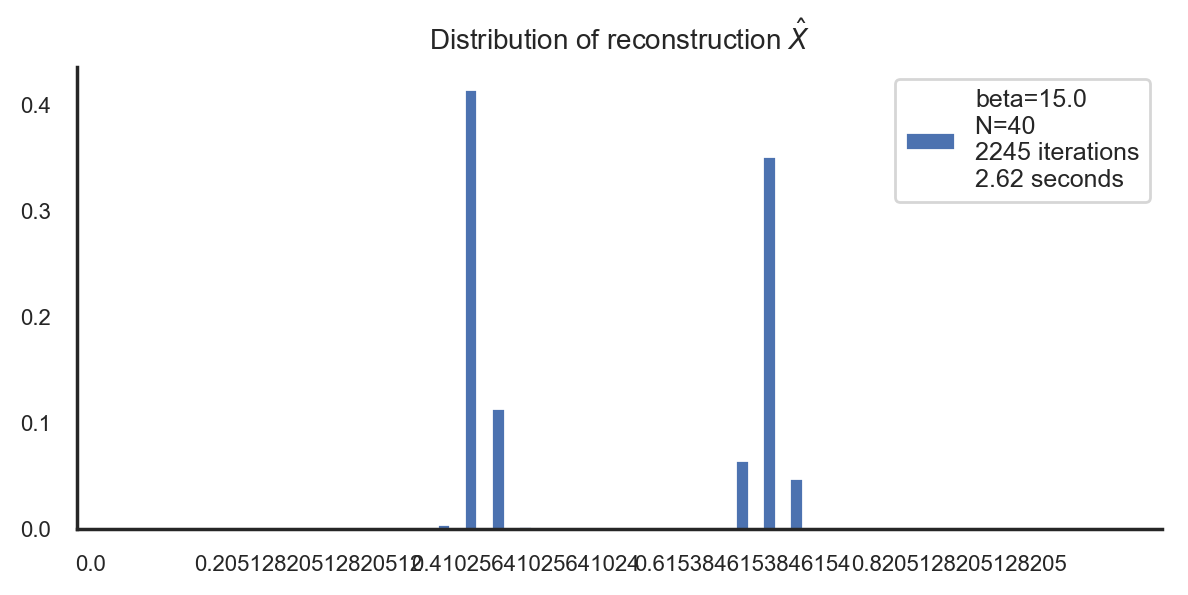

In [10]:
# Blahut-Arimoto
r = BA(X,beta,N=40)
ax = pd.DataFrame(r['q']).plot.bar(title=r'Distribution of reconstruction $\hat{X}$',rot=0,fontsize=8)
ax.legend(['beta={}\nN={} \n{} iterations\n{:.2f} seconds'.format(beta,len(r['q']),r['episodes'],r['elapsed'])])
sns.despine()
xticks = np.arange(0,len(r['q']),8)
plt.xticks(xticks,r['xhat'][xticks])
plt.show()

## 2. Gradient descent ([RD_GD.py](https://github.com/sgttwld/rate-distortion/blob/master/RD_GD.py))
Here, we use that evaluating the auxiliary free energy $F_{aux}$ at the Boltzmann distribution 
$q^\ast(\hat X|X)$ results in
$$
F_{GD}(q(\hat X)) := F_{aux}(q^\ast(\hat{X}|X), q(\hat{X})) 
= -\frac{1}{\beta}\mathbb{E}_X \Big[ \log \mathbb E_{q(\hat{X})} [e^{-\beta d(X,\hat{X})}]  \Big].
$$
which can be optimized with respect to $q(\hat{X})$ by using gradient descent. In particular, exactly as in 
the Blahut-Arimoto algorithm, we __discretize the range of $X$ into $N$ fixed chunks__, which transforms the 
infinite-dimensional optimization problem over distributions $q(\hat{X})$ into an $N$-dimensional optimization 
problem over probability vectors. 

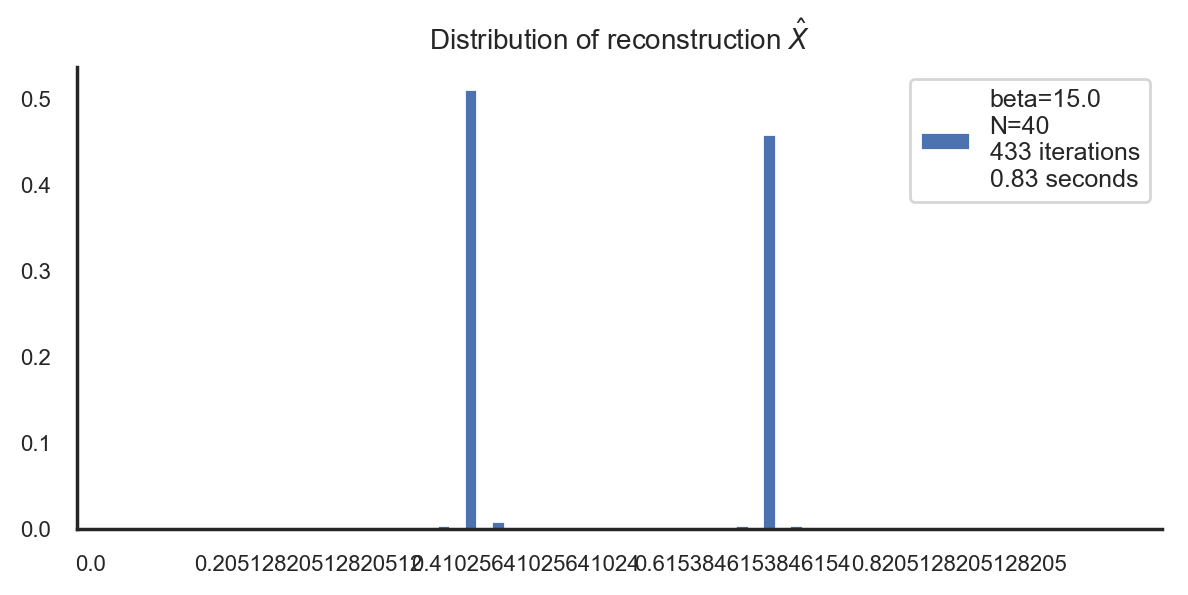

In [11]:
r = GD(X,beta,N=40)
ax = pd.DataFrame(r['q']).plot.bar(title=r'Distribution of reconstruction $\hat{X}$',rot=0,fontsize=8)
ax.legend(['beta={}\nN={}\n{} iterations\n{:.2f} seconds'.format(beta,len(r['q']),r['episodes'],r['elapsed'])])
sns.despine()
xticks = np.arange(0,len(r['q']),8)
plt.xticks(xticks,r['xhat'][xticks])
plt.show()

Note that the above results imply that for our choice of $\beta=15$ the optimal reconstruction has support on only two elements (which are located such that the average distortion is minimized). By increasing $\beta$, there will be several phase transitions where more and more reconstruction points are added. However, __due to the fixed discretization of the range of $X$, the exact support and shape of $q(\hat X)$ can only be approximated__. This issue is resolved by the following approach.

## 3. Mapping approach ([RD_MA.py](https://github.com/sgttwld/rate-distortion/blob/master/RD_MA.py))

The [mapping approach](https://ieeexplore.ieee.org/document/340468) to 
rate-distortion makes use of the Borel isomorphism theorem, which allows to replace the expectation with respect to $q(\hat{X})$ by integration over $u\in [0,1]$ (with respect to the Lebesgue measure) and where 
the value of $\hat X$ is replaced by the value $y(u)$ of some mapping $y:[0,1]\to \mathrm{ran}(X)$, i.e.
$$
\mathbb E_{q(\hat X)}[f(\hat X)] = \int_0^1 f(y(u)) du
$$ 
for any measurable function $f$. Applied to the minimization of the Lagrangian $F_{GD}$ above, this allows 
to replace the optimization of $F_{GD}$ with respect to $q(\hat X)$ by the optimization of 
$$
F_{M}(y) := -\frac{1}{\beta}\mathbb{E}_X \Big[ \log \int_0^1 e^{-\beta d(X,y(u))} du  \Big]
$$
with respect to the mappings $y:[0,1]\to \mathrm{ran}(X)$. 

Instead of discretizing the range of $X$, we can now __discretize the domain of $y$__, so that the optimization 
is over the values $y_i := y(b_i)$ where $(b_i)_{i=1}^N$ are the fixed representatives for each chunk of the 
discretization of $[0,1]$. Note that the difference to the other approaches boils down to how the expectation 
with respect to $q(\hat X)$ is calculated from an $N$-dimensional vector,
$$
\underbrace{\sum_{i=1}^N q_i e^{-\beta d(X,\hat x_i)}}_{\text{1. and 2. above}}  \ \ vs. \ \ \underbrace{\frac{1}{N}\sum_{i=1}^N e^{-\beta d(X,y_i)}}_{\text{mapping approach}}
$$
where $\{\hat x_i\}_{i=1}^N$ is the fixed finite range of $\hat X$ and $q_i:=q(\hat x_i)$ are the optimization 
variables in the above approaches, whereas $y_i = y(b_i)$ are the optimization variables in the mapping 
approach. In particular, here the __possible values of the reconstruction $\hat X$ can perfectly adapt to the 
source $X$__, whereas in the other approaches the possible values are fixed by the discretization.  

We have implemented two different variants of the mapping approach:

__Direct optimization.__ Here we optimize the discretized version of $F_M$,
$$
\tilde F_M(y) := - \frac{1}{\beta} \mathbb E_X\Big[ \log \sum_{i=1}^N e^{-\beta d(X,y_i)} \Big] ,
$$
directly with respect to $y=(y_i)_{i=1}^N$ using gradient descent. 

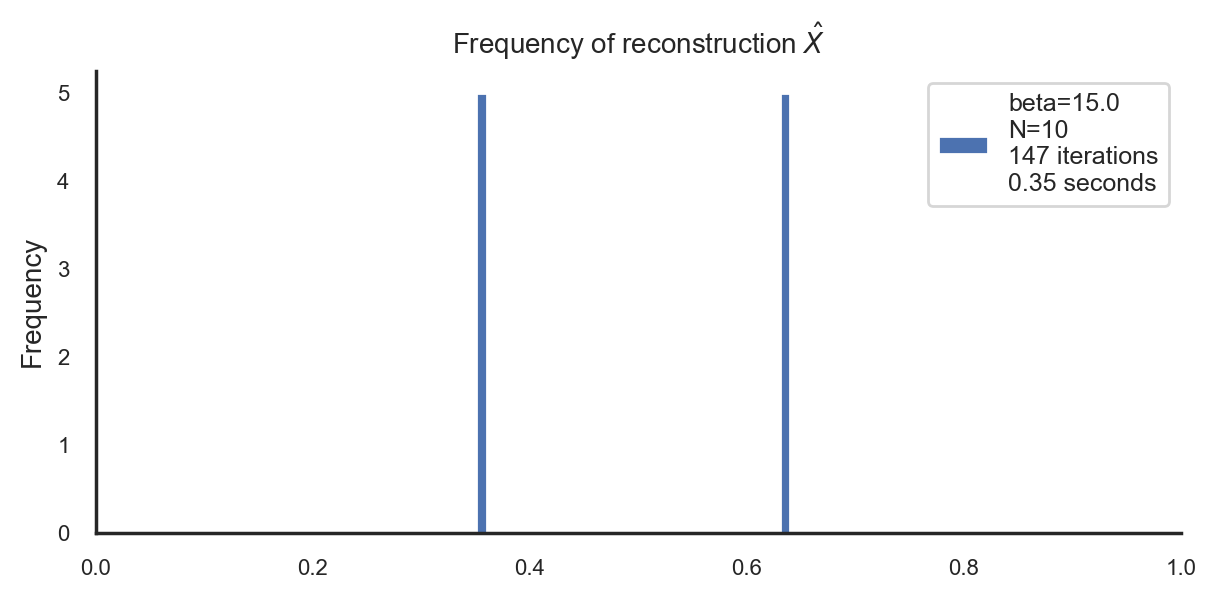

In [12]:
r = MA(X,beta,N=10)
ax = pd.DataFrame(r['Xhat']).plot.hist(bins=100,range=(0,1),title=r'Frequency of reconstruction $\hat X$',fontsize=8)
ax.legend(['beta={}\nN={}\n{} iterations\n{:.2f} seconds'.format(r['beta'],len(r['Xhat']),r['episodes'],r['elapsed'])])
sns.despine()
plt.xlim([0,1])
plt.show()

__Iterative optimization.__ This variant is similar to the Blahut-Arimoto algorithm above, in that it makes use of the fact that the 
discretized version of $F_M(y)$ can be written as 
$$
\tilde F_M(y) = \min_{q(I|X)} F'_{aux}(y,q(I|X))
$$
with the auxiliary Lagrangian (see e.g. [Gottwald, Braun 2020](https://arxiv.org/abs/2004.11763))
$$
F'_{aux}(y,q(I|x)) := \mathbb E_{X} \Big[ \mathbb E_{q(I|X)}[d(X,y_I)] + \tfrac{1}{\beta} D_{KL}(q(I|X)\|\tfrac{1}{N})\Big].
$$
Minimizing $F'_{aux}$ separately in each argument yields the closed-form solutions 
$$
q^\ast(I|X=x) = \frac{e^{-\beta d(x,y_i)}}{\sum_j e^{-\beta d(x,y_j)}} \ , \ \ y^\ast_i = E[X|I{=}i] = \frac{\mathbb E_X[X q(i|X)]}{E_X[q(i|X)]}
$$
where the solution for $y^\ast$ is only valid for Bregman distortion measures (see e.g. 
[Banerjee 2005](https://ecommons.cornell.edu/bitstream/handle/1813/9264/TR001387.pdf?sequence=1)). Iterating these
equation yields an algorithm similar to the Blahut-Arimoto algorithm, which will have performance characteristics that 
are different from the direct optimization above.

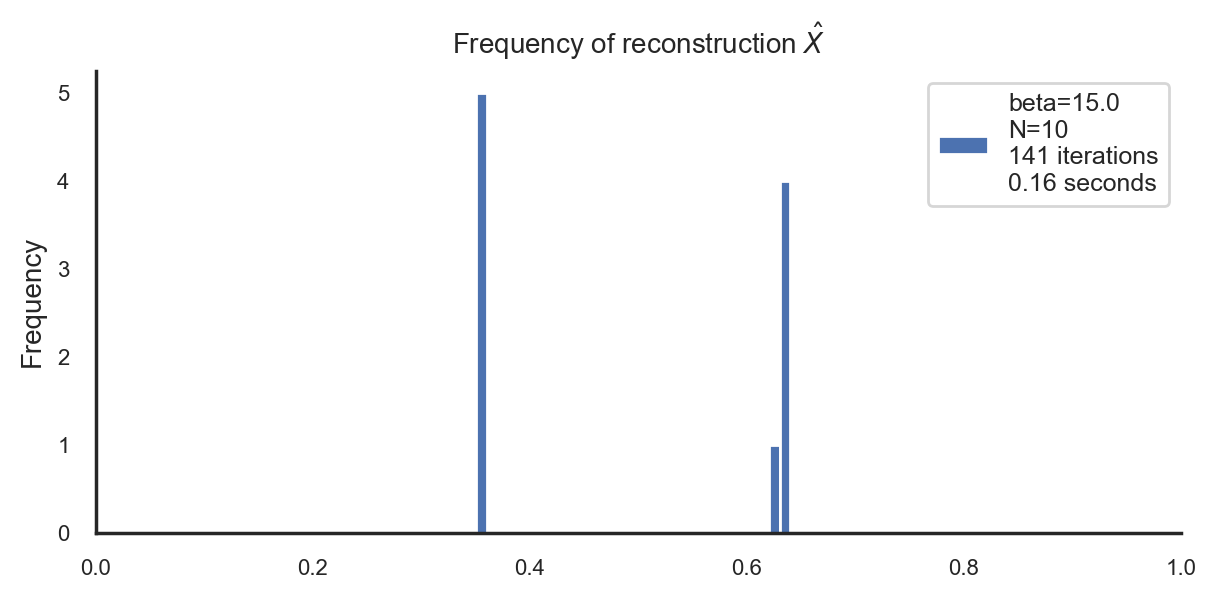

In [13]:
# Mapping approach (iterative algorithm)
r = MA_iter(X,beta,N=10)
ax = pd.DataFrame(r['Xhat']).plot.hist(bins=100,range=(0,1),title=r'Frequency of reconstruction $\hat X$',fontsize=8)
ax.legend(['beta={}\nN={}\n{} iterations\n{:.2f} seconds'.format(r['beta'],len(r['Xhat']),r['episodes'],r['elapsed'])])
sns.despine()
plt.xlim([0,1])
plt.show()

<div class='name'>24.05.2020,<br> <a href='https://gttwld.de'><i>Sebastian Gottwald</i></a></div>